# 🌳🌳🌳 Решающие деревья, случайный лес

✅ Реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. 
- При решении задачи регрессии используйте дисперсию подвыборки
- При решении задачи классификации используйте критерий Джини

Функцию`find_best_split` протестируйте на датасете `Boston` из `sklearn`

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. 

In [1]:
!pip install "scikit-learn<1.2" #после этой строчки перезапустите ядро ноутбука

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 669.3 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [5]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


array([[ 3,  0,  4, ...,  6,  9, 11],
       [ 1,  3,  0, ...,  6,  9, 11],
       [ 1,  3,  0, ...,  6,  9, 11],
       ...,
       [ 1,  3,  0, ...,  6,  9, 11],
       [ 1,  3,  0, ...,  6,  9, 11],
       [ 1,  3,  0, ...,  6,  9, 11]])

In [21]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis/variances: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best/variance_best: оптимальное значение критерия Джини/дисперсии (число)
    """
    sorted_indices = np.argsort(feature_vector)
    feature_vector_sorted = feature_vector[sorted_indices]
    target_vector_sorted = target_vector[sorted_indices]
    thresholds = []
    criterion_values = []
    n = len(feature_vector_sorted)
    
    if task == 'regression':
        for i in range(1, n):
            if feature_vector_sorted[i] != feature_vector_sorted[i-1]:
                # Порог как среднее между двумя соседними значениями
                threshold = (feature_vector_sorted[i] + feature_vector_sorted[i-1]) / 2
                thresholds.append(threshold)
            
            # Разделяем данные по порогу
                left_indices = feature_vector_sorted <= threshold
                right_indices = feature_vector_sorted > threshold
            
                y_left = target_vector_sorted[left_indices]
                y_right = target_vector_sorted[right_indices]
            
            # Проверяем, что нет пустых подвыборок
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                left_score = np.var(y_left)
                right_score = np.var(y_right)
                score = (len(y_left) * left_score + len(y_right) * right_score) / n
                criterion_values.append(score)
        if not thresholds:
            return None, None, None, None
    
        # Находим оптимальный порог (минимальный критерий)
        best_index = np.argmin(criterion_values)
        threshold_best = thresholds[best_index]
        criterion_best = criterion_values[best_index]
        
        return (thresholds, criterion_values, threshold_best, criterion_best)
    
    
    
    elif task == 'classification': #рассматриваем бинарную классификацию
        for i in range(1, n):
            if feature_vector_sorted[i] != feature_vector_sorted[i-1]:
                # Порог как среднее между двумя соседними значениями
                threshold = (feature_vector_sorted[i] + feature_vector_sorted[i-1]) / 2
                thresholds.append(threshold)
            
            # Разделяем данные по порогу
                left_indices = feature_vector_sorted <= threshold
                right_indices = feature_vector_sorted > threshold
            
                y_left = target_vector_sorted[left_indices]
                y_right = target_vector_sorted[right_indices]
            
            # Проверяем, что нет пустых подвыборок
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                _, counts = np.unique(y_left, return_counts=True)
                probabilities = counts / counts.sum()
                y_left =  1 - np.sum(probabilities ** 2)
                
                _, counts = np.unique(y_right, return_counts=True)
                probabilities = counts / counts.sum()
                y_right =  1 - np.sum(probabilities ** 2)

                score = (len(y_left) * left_score + len(y_right) * right_score) / n
                criterion_values.append(score)

        if not thresholds:
            return None, None, None, None
    
        # Находим оптимальный порог (минимальный критерий)
        best_index = np.argmin(criterion_values)
        threshold_best = thresholds[best_index]
        criterion_best = criterion_values[best_index]
        
        return (thresholds, criterion_values, threshold_best, criterion_best)
               

    

In [23]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

**Посмотрим на самый оптимальный порог**

In [25]:
threshold_best

6.68632

**Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.**

(5.0, 85.317523)

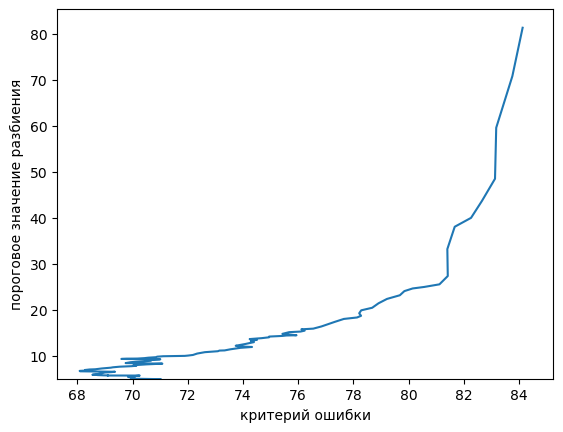

In [39]:
plt.plot(variances, thresholds)
plt.xlabel('критерий ошибки')
plt.ylabel('пороговое значение разбиения')
plt.ylim(5)